# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Наша задача, построить модель для задачи классификации, которая выберет подходящий тариф. Доля правильных ответов модели должна быть не меньше 75%.

## Откроем и изучим файл

Загрузим нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier

Загрузим файл в переменную df_behavior и посмотрим на данные

In [2]:
try:
    df_behavior = pd.read_csv(r'users_behavior.csv')
    df_behavior.head()
except:
    df_behavior = pd.read_csv('/datasets/users_behavior.csv')
    df_behavior.head()

In [3]:
df_behavior.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Мы видим уже предобработаные данные готовые к дальнешей работе

## Разобьем данные на выборки

Разобьем данные на 3 выборки, тренировочную, валидационную и тестовую в соотношении 60%-20%-20%

In [4]:
features = df_behavior.drop('is_ultra', axis=1)
target = df_behavior['is_ultra']

features_train, features_tv, target_train, target_tv = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_tv, target_tv, test_size=0.5, random_state=12345)

In [5]:
print('features_train :\n', target_train.value_counts(),
     '\nfeatures_valid :\n', target_valid.value_counts(),
     '\nfeatures_test :\n', target_test.value_counts()
     )

features_train :
 0    1335
1     593
Name: is_ultra, dtype: int64 
features_valid :
 0    440
1    203
Name: is_ultra, dtype: int64 
features_test :
 0    454
1    189
Name: is_ultra, dtype: int64


## Исследуем модели

Создадим и обучим модель дерева решений

In [6]:
tree = DecisionTreeClassifier()
tree.fit(features_train, target_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Подберем лучшие параметры с помошью поиска по сетке и поместим лучшую модель в переменную best_tree

In [7]:
tree_params = {'max_depth': range(1,11),
'max_features': range(1,4),
'criterion': ['gini', 'entropy'],
'random_state': [12345]}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(features_train, target_train)
best_tree = tree_grid.best_estimator_
# так же выведем accuracy на экран
print("Accuracy наилучшей модели на валидационной выборке:", accuracy_score(target_valid, best_tree.predict(features_valid)))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.5s


Accuracy наилучшей модели на валидационной выборке: 0.7900466562986003


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   49.2s finished


Создадим модель слечайного леса и подберем для нее лучшие гиперпараметры через случайный поиск

In [8]:
rfc = RandomForestClassifier()

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
forest_param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state': [12345]}
forest_rs = RandomizedSearchCV(rfc, 
                        forest_param, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
forest_rs.fit(features_train, target_train)
best_forest = forest_rs.best_estimator_
# выведем accuracy на экран
print("Accuracy наилучшей модели на валидационной выборке:", accuracy_score(target_valid, best_forest.predict(features_valid)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


Accuracy наилучшей модели на валидационной выборке: 0.7993779160186625


Создадим модель логистической регрессии и найдем лучшие параметры через поиск по сетке 

In [9]:
lr = LogisticRegression()
param_grid = [    
    {'penalty' : ['l1', 'l2'],
    'C': np.arange(1e-02, 1, 0.01),
    'solver' : ['liblinear'],
    'random_state': [12345],
    'max_iter' : [100, 1000, 2500, 5000]}
]

gs= GridSearchCV(lr, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

gs.fit(features_train, target_train)
results = gs.cv_results_
best_lr = gs.best_estimator_
# выведем accuracy на экран
print("Accuracy наилучшей модели на валидационной выборке:", accuracy_score(target_valid, best_lr.predict(features_valid)))

Fitting 3 folds for each of 792 candidates, totalling 2376 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.0s


Accuracy наилучшей модели на валидационной выборке: 0.7402799377916018


[Parallel(n_jobs=-1)]: Done 2376 out of 2376 | elapsed:    8.4s finished


### Вывод

По результатам исследования моделей мы видим, что наилучшие результаты показала модель случайного леса, за ней с небольшим отставанием идет дерево решений, а вот линейная регрессия показала себя хуже всего и не перешла порог accuracy в 0.75

## Проверим модель на тестовой выборке

Проверим модели на тестовой выборке и оценим качество обучения 

Построим таблицу сводную таблицу 

In [10]:
data = [
    ['tree', accuracy_score(target_valid, best_tree.predict(features_valid))
     , accuracy_score(target_test, best_tree.predict(features_test))],
    ['forest', accuracy_score(target_valid, best_forest.predict(features_valid))
     , accuracy_score(target_test, best_forest.predict(features_test))],
    ['logreg', accuracy_score(target_valid, best_lr.predict(features_valid))
     , accuracy_score(target_test, best_lr.predict(features_test))]
]
columns = ['model', 'valid', 'test']
pivot_ml = pd.DataFrame(data=data, columns=columns)
pivot_ml

,model,valid,test
0,tree,0.790047,0.794712
1,forest,0.799378,0.796267
2,logreg,0.740280,0.755832


Построим для наглядности график

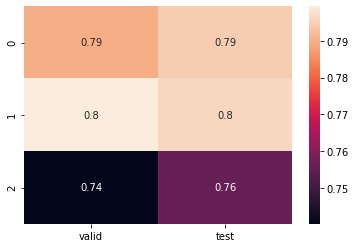

In [11]:
sns.heatmap(pivot_ml[['valid', 'test']], annot=True)

### Вывод

Мы видим что модели обучились хорошо и нет следов переобучения или недообучения

## (бонус) Проверим модели на адекватность

Создадим константную модель и проверим наши модели

In [12]:
clf_dummy = DummyClassifier(strategy='most_frequent', random_state=42)
clf_dummy.fit(features_train, target_train)

DummyClassifier(constant=None, random_state=42, strategy='most_frequent')

Протестируем наши модели, если показатели accuracy костантной модели будет выше, то модель не адекватна

Напишем функцию для сравнения значений

In [13]:
def neodekvat(test, const):
    if test > const:
        print("Accuracy на тестовой выборке выше, модель адекватна",
              '\nAccuracy тест =', test,
              '\nAccuracy константы =', const
             )
    else:
        print("Accuracy на тестовой выборке ниже, модель неадекватна",
              '\nAccuracy тест =', test,
              '\nAccuracy константы =', const
             )   

Проверим дерево решений

In [14]:
neodekvat(accuracy_score(target_test, best_tree.predict(features_test)),
          accuracy_score(target_test, clf_dummy.predict(features_test)))

Accuracy на тестовой выборке выше, модель адекватна 
Accuracy тест = 0.7947122861586314 
Accuracy константы = 0.7060653188180405


Случайный лес

In [15]:
neodekvat(accuracy_score(target_test, best_forest.predict(features_test)),
          accuracy_score(target_test, clf_dummy.predict(features_test)))

Accuracy на тестовой выборке выше, модель адекватна 
Accuracy тест = 0.7962674961119751 
Accuracy константы = 0.7060653188180405


И логистическую регрессию

In [16]:
neodekvat(accuracy_score(target_test, best_lr.predict(features_test)),
          accuracy_score(target_test, clf_dummy.predict(features_test)))

Accuracy на тестовой выборке выше, модель адекватна 
Accuracy тест = 0.7558320373250389 
Accuracy константы = 0.7060653188180405


Все модели прошли проверку на адекватность!

## Общий вывод

По результатам исследования мы можем выбрать одну из 2х моделей, либо дерево решений либо случайный лес. При выборе из них мы можем руководствоваться фактором времени работы моделей. При том, что дерево решений показывает предсказывает чуть-чуть хуже случайного леса, работает оно значительно быстрее, чем и выигрывает у случайного леса.